<a href="https://colab.research.google.com/github/Arun2005-create/Ex1-AAI/blob/main/Applied_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pybbn

  Preparing metadata (setup.py) ... done
  Created wheel for pybbn: filename=pybbn-3.2.3-py3-none-any.whl size=40372 sha256=a88902fab53b5a24324b22a52fa715f3277a932a67e73afe32ecf71684cf2de4
  Stored in directory: /root/.cache/pip/wheels/07/00/f6/a1ad0aa73a832ed29ae62a32a5bd05a911596be0d8d7cc7ad6
Successfully built pybbn


       Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0        Albury     13.4     22.9       0.6     5.469824  7.624853   
1        Albury      7.4     25.1       0.0     5.469824  7.624853   
2        Albury     12.9     25.7       0.0     5.469824  7.624853   
3        Albury      9.2     28.0       0.0     5.469824  7.624853   
4        Albury     17.5     32.3       1.0     5.469824  7.624853   
...         ...      ...      ...       ...          ...       ...   
145454    Uluru      3.5     21.8       0.0     5.469824  7.624853   
145455    Uluru      2.8     23.4       0.0     5.469824  7.624853   
145456    Uluru      3.6     25.3       0.0     5.469824  7.624853   
145457    Uluru      5.4     26.9       0.0     5.469824  7.624853   
145458    Uluru      7.8     27.0       0.0     5.469824  7.624853   

       WindGustDir  WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  \
0                W           44.0          W        WNW          20.0   
1            

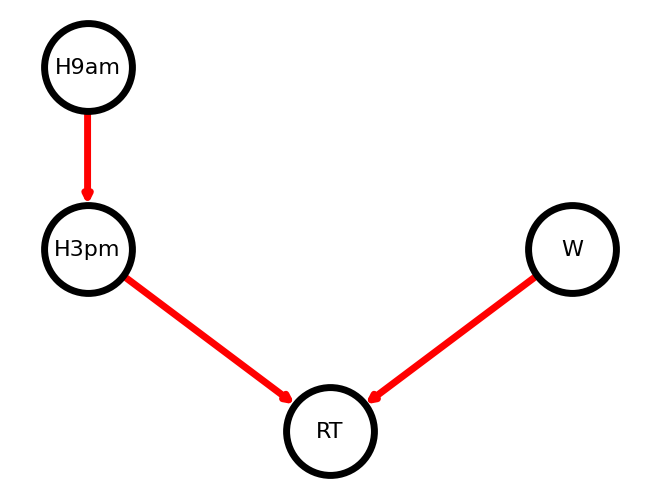

[0.30658330578861126, 0.6934166942113887]
[0.928269945405331, 0.071730054594669, 0.5576020040771205, 0.44239799592287954]
[0.5865970898708094, 0.24039861315254618, 0.1730042969766444]
[0.9231423408100351, 0.07685765918996491, 0.8907156673114119, 0.109284332688588, 0.7600840888188148, 0.23991591118118513, 0.6425022248590923, 0.35749777514090775, 0.4916834919719258, 0.5083165080280743, 0.3218170185540627, 0.6781829814459372]


In [ ]:
import pandas as pd # for data manipulation
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs
# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController
#Set Pandas options to display more columns
pd.options.display.max_columns=50

# Read in the weather data csv
df=pd.read_csv('/content/weatherAUS.csv', encoding='utf-8')

# Drop records where target RainTomorrow=NaN
df=df[pd.isnull(df['RainTomorrow'])==False]
# Drop the 'Date' column as it is not relevant for the model
df = df.drop(columns='Date')

# For other columns with missing values, fill them in with column mean for numeric columns only
numeric_columns = df.select_dtypes(include=['number']).columns
# Use .loc to explicitly modify the original DataFrame
df.loc[:, numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Create bands for variables that we want to use in the model
df['WindGustSpeedCat']=df['WindGustSpeed'].apply(lambda x: '0.<=40'   if x<=40 else
                                                            '1.40-50' if 40<x<=50 else '2.>50')
df['Humidity9amCat']=df['Humidity9am'].apply(lambda x: '1.>60' if x>60 else '0.<=60')
df['Humidity3pmCat']=df['Humidity3pm'].apply(lambda x: '1.>60' if x>60 else '0.<=60')


# Show a snaphsot of data
print(df)

# This function helps to calculate probability distribution, which goes into BBN (note, can handle up to 2 parents)
def probs(data, child, parent1=None, parent2=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:
                # Caclucate probabilities
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob
# Create nodes by using our earlier function to automatically calculate probabilities
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), probs(df, child='Humidity9amCat'))
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), probs(df, child='Humidity3pmCat', parent1='Humidity9amCat'))
W = BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), probs(df, child='WindGustSpeedCat'))
RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), probs(df, child='RainTomorrow', parent1='Humidity3pmCat', parent2='WindGustSpeedCat'))

# Create Network
bbn = Bbn() \
    .add_node(H9am) \
    .add_node(H3pm) \
    .add_node(W) \
    .add_node(RT) \
    .add_edge(Edge(H9am, H3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(H3pm, RT, EdgeType.DIRECTED)) \
    .add_edge(Edge(W, RT, EdgeType.DIRECTED))

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)
# Set node positions
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 0.5), 3: (0, -1)}

# Set options for graph looks
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 5,
    "width": 5,}

# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()
print(probs(df, child='Humidity9amCat'))
print(probs(df, child='Humidity3pmCat', parent1='Humidity9amCat'))
print(probs(df, child='WindGustSpeedCat'))
print(probs(df, child='RainTomorrow', parent1='Humidity3pmCat', parent2='WindGustSpeedCat'))

In [ ]:
!pip install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [ ]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import VariableElimination

In [ ]:
alarm_model = DiscreteBayesianNetwork(
    [
        ("Burglary", "Alarm"),
        ("Earthquake", "Alarm"),
        ("Alarm", "JohnCalls"),
        ("Alarm", "MaryCalls"),
    ]
)

# Defining the parameters using CPT
from pgmpy.factors.discrete import TabularCPD

cpd_burglary = TabularCPD(
    variable="Burglary", variable_card=2, values=[[0.999], [0.001]]
)
cpd_earthquake = TabularCPD(
    variable="Earthquake", variable_card=2, values=[[0.998], [0.002]]
)
cpd_alarm = TabularCPD(
    variable="Alarm",
    variable_card=2,
    values=[[0.999, 0.71, 0.06, 0.05], [0.001, 0.29, 0.94, 0.95]],
    evidence=["Burglary", "Earthquake"],
    evidence_card=[2, 2],
)
cpd_johncalls = TabularCPD(
    variable="JohnCalls",
    variable_card=2,
    values=[[0.95, 0.1], [0.05, 0.9]],
    evidence=["Alarm"],
    evidence_card=[2],
)
cpd_marycalls = TabularCPD(
    variable="MaryCalls",
    variable_card=2,
    values=[[0.99, 0.3], [0.01, 0.7]],
    evidence=["Alarm"],
    evidence_card=[2],
)

# Associating the parameters with the model structure
alarm_model.add_cpds(
    cpd_burglary, cpd_earthquake, cpd_alarm, cpd_johncalls, cpd_marycalls
)

In [ ]:
alarm_model.check_model()

In [ ]:
inference=VariableElimination(alarm_model)

In [ ]:
nference=VariableElimination(alarm_model)

In [ ]:
evidence={"JohnCalls":1,"MaryCalls":0}

In [ ]:
query='Burglary'

In [ ]:
res=inference.query(variables=[query],evidence=evidence)

In [ ]:
print(res)

+-------------+-----------------+
| Burglary    |   phi(Burglary) |
+=============+=================+
| Burglary(0) |          0.9949 |
+-------------+-----------------+
| Burglary(1) |          0.0051 |
+-------------+-----------------+


In [ ]:
evidence2={"JohnCalls":1,"MaryCalls":1}

In [ ]:
res2=inference.query(variables=[query],evidence=evidence2)

In [ ]:
print(res2)

+-------------+-----------------+
| Burglary    |   phi(Burglary) |
+=============+=================+
| Burglary(0) |          0.7158 |
+-------------+-----------------+
| Burglary(1) |          0.2842 |
+-------------+-----------------+


In [ ]:
!pip install networkx

In [ ]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import GibbsSampling
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
alarm_model = DiscreteBayesianNetwork(
    [
        ("Burglary", "Alarm"),
        ("Earthquake", "Alarm"),
        ("Alarm", "JohnCalls"),
        ("Alarm", "MaryCalls"),
    ]
)

# Defining the parameters using CPT
from pgmpy.factors.discrete import TabularCPD

cpd_burglary = TabularCPD(
    variable="Burglary", variable_card=2, values=[[0.999], [0.001]]
)
cpd_earthquake = TabularCPD(
    variable="Earthquake", variable_card=2, values=[[0.998], [0.002]]
)
cpd_alarm = TabularCPD(
    variable="Alarm",
    variable_card=2,
    values=[[0.999, 0.71, 0.06, 0.05], [0.001, 0.29, 0.94, 0.95]],
    evidence=["Burglary", "Earthquake"],
    evidence_card=[2, 2],
)
cpd_johncalls = TabularCPD(
    variable="JohnCalls",
    variable_card=2,
    values=[[0.95, 0.1], [0.05, 0.9]],
    evidence=["Alarm"],
    evidence_card=[2],
)
cpd_marycalls = TabularCPD(
    variable="MaryCalls",
    variable_card=2,
    values=[[0.1, 0.7], [0.9, 0.3]],
    evidence=["Alarm"],
    evidence_card=[2],
)

# Associating the parameters with the model structure
alarm_model.add_cpds(
    cpd_burglary, cpd_earthquake, cpd_alarm, cpd_johncalls, cpd_marycalls
)

In [ ]:
print("Bayesian Network Structure")
print(alarm_model)

Bayesian Network Structure
DiscreteBayesianNetwork with 5 nodes and 4 edges


In [ ]:
G=nx.DiGraph()

In [ ]:
nodes=['Burglary','Earthquake','JohnCalls','MaryCalls']
edges=[('Burglary','Alarm'),('Earthquake','Alarm'),('Alarm','JohnCalls'),('Alarm','MaryCalls')]

In [ ]:
G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [ ]:
pos={
    'Burglary':(0,0),
    'Earthquake':(2,0),
    'Alarm':(1,-2),
    'JohnCalls':(0,-4),
    'MaryCalls':(2,-4)
    }

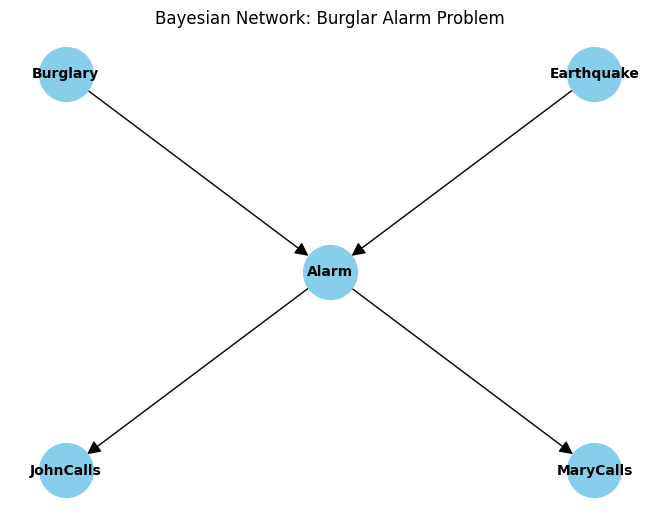

In [ ]:
nx.draw(G,pos,with_labels=True,node_size=1500,node_color="skyblue",font_size=10,font_weight="bold",arrowsize=20)
plt.title("Bayesian Network: Burglar Alarm Problem")
plt.show()

In [ ]:
gibbssampler=GibbsSampling(alarm_model)

In [ ]:
num_samples=10000

In [ ]:
samples=gibbssampler.sample(size=num_samples)

  0%|          | 0/9999 [00:00<?, ?it/s]

In [ ]:
query_variable="Burglary"
query_result=samples[query_variable].value_counts(normalize=True)

In [ ]:
print("\n Approximate probabilities of {}:".format(query_variable))
print(query_result)


 Approximate probabilities of Burglary:
Burglary
0    0.9992
1    0.0008
Name: proportion, dtype: float64
